# **KGFarm**
**A Feature Discovery system for Machine learning workflows**
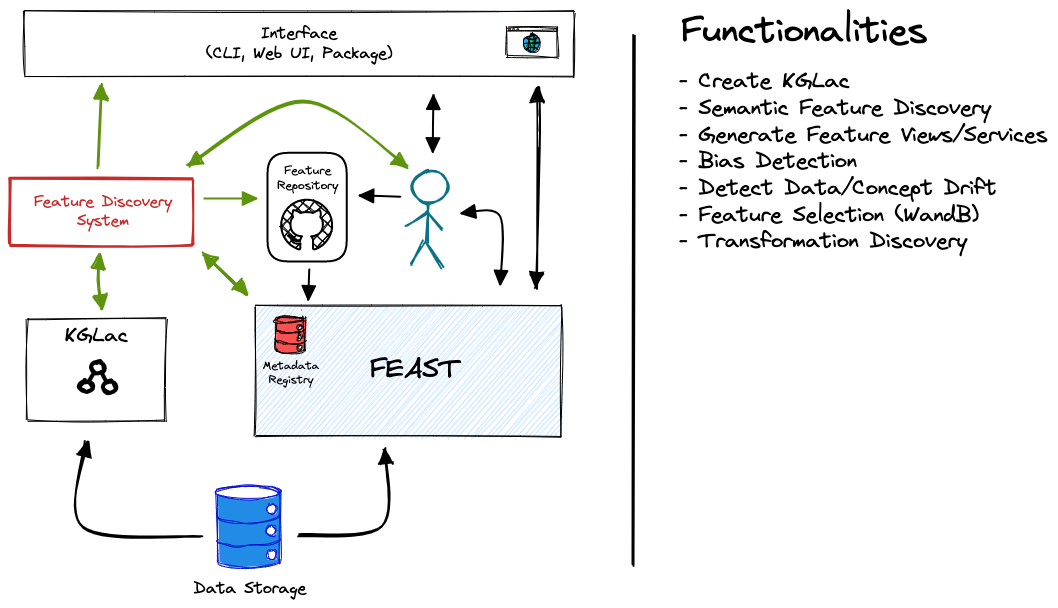






In [1]:
from feature_discovery.src.api.api import KGFarm
kgfarm = KGFarm()

Connected to Stardog!
Access the Stardog UI at: https://cloud.stardog.com/


**Predicting [Entities](https://docs.feast.dev/getting-started/concepts/entity) & [Feature Views](https://docs.feast.dev/getting-started/concepts/feature-view)**
  *   To modify the path to the feature repo, pass the updated path as the param to the instance of KGFarm
  *   To finalize certain set of Feature views use KGFarm's <code>finalize_feature_views()</code> API.







In [2]:
kgfarm.show_entities()

,Entity,Entity_data_type,Physical_column,Physical_table,Uniqueness_ratio
0,account__completedacct,STRING,account_id,completedacct.parquet,1.000000
1,card__completedcard,STRING,card_id,completedcard.parquet,1.000000
2,loan__luxuryloanportfolio,STRING,loan_id,luxuryloanportfolio.parquet,1.000000
3,account__completedloan,STRING,account_id,completedloan.parquet,1.000000
4,district__completeddistrict,INT64,district_id,completeddistrict.parquet,1.000000
5,client__completeddisposition,INT64,client_id,completeddisposition.parquet,1.000000
6,order__completedorder,INT64,order_id,completedorder.parquet,1.000000
7,client__completedclient,STRING,client_id,completedclient.parquet,1.000000
8,account__month_summary,STRING,account_id,month_summary.parquet,0.765957
9,client__month_summary,INT64,client_id,month_summary.parquet,0.781915


In [3]:
feature_view_df = kgfarm.show_feature_views()
feature_view_df

,Feature_view,Entity,Physical_table,File_source
0,Feature_view_1,[loan__luxuryloanportfolio],luxuryloanportfolio.parquet,/Users/shubhamvashisth/Documents/CoDS/projects...
1,Feature_view_10,[card__completedcard],completedcard.parquet,/Users/shubhamvashisth/Documents/CoDS/projects...
2,Feature_view_11,None,district.parquet,/Users/shubhamvashisth/Documents/CoDS/projects...
3,Feature_view_12,None,account.parquet,/Users/shubhamvashisth/Documents/CoDS/projects...
4,Feature_view_13,"[account__month_summary, client__month_summary]",month_summary.parquet,/Users/shubhamvashisth/Documents/CoDS/projects...
5,Feature_view_14,None,client.parquet,/Users/shubhamvashisth/Documents/CoDS/projects...
6,Feature_view_2,[account__completedloan],completedloan.parquet,/Users/shubhamvashisth/Documents/CoDS/projects...
7,Feature_view_3,[account__completedacct],completedacct.parquet,/Users/shubhamvashisth/Documents/CoDS/projects...
8,Feature_view_4,[client__completedclient],completedclient.parquet,/Users/shubhamvashisth/Documents/CoDS/projects...
9,Feature_view_5,None,crm_call_center_logs.parquet,/Users/shubhamvashisth/Documents/CoDS/projects...


**Drop Feature Views**
  *   Pass the feature views to be deleted as a <code>pandas.Series</code> object.


In [4]:
kgfarm.drop_feature_view(drop=[feature_view_df.iloc[12], feature_view_df.iloc[13]])

Dropped Feature_view_8 Feature_view_9 

,Feature_view,Entity,Physical_table,File_source
0,Feature_view_1,[loan__luxuryloanportfolio],luxuryloanportfolio.parquet,/Users/shubhamvashisth/Documents/CoDS/projects...
1,Feature_view_10,[card__completedcard],completedcard.parquet,/Users/shubhamvashisth/Documents/CoDS/projects...
2,Feature_view_11,None,district.parquet,/Users/shubhamvashisth/Documents/CoDS/projects...
3,Feature_view_12,None,account.parquet,/Users/shubhamvashisth/Documents/CoDS/projects...
4,Feature_view_13,"[account__month_summary, client__month_summary]",month_summary.parquet,/Users/shubhamvashisth/Documents/CoDS/projects...
5,Feature_view_14,None,client.parquet,/Users/shubhamvashisth/Documents/CoDS/projects...
6,Feature_view_2,[account__completedloan],completedloan.parquet,/Users/shubhamvashisth/Documents/CoDS/projects...
7,Feature_view_3,[account__completedacct],completedacct.parquet,/Users/shubhamvashisth/Documents/CoDS/projects...
8,Feature_view_4,[client__completedclient],completedclient.parquet,/Users/shubhamvashisth/Documents/CoDS/projects...
9,Feature_view_5,None,crm_call_center_logs.parquet,/Users/shubhamvashisth/Documents/CoDS/projects...


**Update Entity for a particular Feature_view**
  *   Use KGFarm's <code>get_optional_entities()</code> to discover other promising entities.
  *   To update a feature view with entity of your choice. Use KGFarm's <code>update_entity()</code> API. 
  *   Pass your choice from <code>get_optional_entities()</code> to <code>update_entity(entity_to_update_info: pd.Series)</code>.

In [5]:
optional_entities_df = kgfarm.get_optional_entities()
optional_entities_df

,Optional_entity,Entity_data_type,Physical_column,Physical_table,Uniqueness_ratio,Feature_view
0,[social_luxuryloanportfolio],STRING,social,luxuryloanportfolio.parquet,1.000000,Feature_view_1
1,[phone_luxuryloanportfolio],STRING,phone,luxuryloanportfolio.parquet,1.000000,Feature_view_1
2,[loan_balance_luxuryloanportfolio],INT64,loan_balance,luxuryloanportfolio.parquet,0.998212,Feature_view_1
3,[payments_luxuryloanportfolio],INT64,payments,luxuryloanportfolio.parquet,0.989869,Feature_view_1
4,[property_value_luxuryloanportfolio],INT64,property_value,luxuryloanportfolio.parquet,0.974374,Feature_view_1
5,[disp__completedcard],STRING,disp_id,completedcard.parquet,1.000000,Feature_view_10
6,[loan__completedloan],INT64,loan_id,completedloan.parquet,1.000000,Feature_view_2
7,[email_completedclient],STRING,email,completedclient.parquet,1.000000,Feature_view_4
8,[social_completedclient],STRING,social,completedclient.parquet,1.000000,Feature_view_4
9,[phone_completedclient],STRING,phone,completedclient.parquet,1.000000,Feature_view_4


In [7]:
kgfarm.update_entity(optional_entities_df.iloc[0])

Feature_view_1 Updated!
Feature_view_1 now uses 'social_luxuryloanportfolio' entity


,Feature_view,Entity,Physical_table,File_source
0,Feature_view_1,[social_luxuryloanportfolio],luxuryloanportfolio.parquet,/Users/shubhamvashisth/Documents/CoDS/projects...
1,Feature_view_10,[card__completedcard],completedcard.parquet,/Users/shubhamvashisth/Documents/CoDS/projects...
2,Feature_view_11,None,district.parquet,/Users/shubhamvashisth/Documents/CoDS/projects...
3,Feature_view_12,None,account.parquet,/Users/shubhamvashisth/Documents/CoDS/projects...
4,Feature_view_13,"[account__month_summary, client__month_summary]",month_summary.parquet,/Users/shubhamvashisth/Documents/CoDS/projects...
5,Feature_view_14,None,client.parquet,/Users/shubhamvashisth/Documents/CoDS/projects...
6,Feature_view_2,[account__completedloan],completedloan.parquet,/Users/shubhamvashisth/Documents/CoDS/projects...
7,Feature_view_3,[account__completedacct],completedacct.parquet,/Users/shubhamvashisth/Documents/CoDS/projects...
8,Feature_view_4,[client__completedclient],completedclient.parquet,/Users/shubhamvashisth/Documents/CoDS/projects...
9,Feature_view_5,None,crm_call_center_logs.parquet,/Users/shubhamvashisth/Documents/CoDS/projects...


**Finalize Feature Views**
  *   Pass the [time to leave](https://docs.feast.dev/getting-started/concepts/point-in-time-joins) (<code>ttl</code> in days) parameter to <code>kgfarm.finalize_feature_views()</code> API.


In [8]:
kgfarm.finalize_feature_views(ttl=30)

Finalizing feature views


100%|██████████| 12/12 [00:00<00:00, 35494.82it/s]

Predicted feature view(s) file saved at:  /Users/shubhamvashisth/Documents/CoDS/projects/KGFarm/feature_repo/predicted_register.py


## **Using [Feast](https://docs.feast.dev/) as the feature store** 

  **Register feature definitions and deploy your feature store using <code>feast apply</code>** [(more info)](https://docs.feast.dev/getting-started/quickstart#step-3-register-feature-definitions-and-deploy-your-feature-store)


![feast_workflow.png](https://1650793599-files.gitbook.io/~/files/v0/b/gitbook-x-prod.appspot.com/o/spaces%2FVkSG27xI2Nd7tq6rJzMY%2Fuploads%2Fgit-blob-0a7b044b098864001876e11fbb35bfe04007bb60%2Ffeast-marchitecture.png?alt=media)

In [9]:
from feast import FeatureStore
import os

os.chdir('feature_repo/')
!feast apply
os.chdir('../')
store = FeatureStore('feature_repo/')

Created entity client__completedclient
Created entity account__completedloan
Created entity account__completedacct
Created entity loan__luxuryloanportfolio
Created entity order__completedorder
Created entity card__completedcard
Created entity account__month_summary
Created entity client__completeddisposition
Created entity client__month_summary
Created entity social_luxuryloanportfolio
Created entity district__completeddistrict
Created feature view Feature_view_7
Created feature view Feature_view_1
Created feature view Feature_view_5
Created feature view Feature_view_13
Created feature view Feature_view_14
Created feature view Feature_view_6
Created feature view Feature_view_12
Created feature view Feature_view_10
Created feature view Feature_view_3
Created feature view Feature_view_11
Created feature view Feature_view_2
Created feature view Feature_view_4

Created sqlite table feature_repo_Feature_view_7
Created sqlite table feature_repo_Feature_view_1
Created sqlite table feature_rep

## **Using Discovery operations by KGLiDS**

In [11]:
import sys
import pandas as pd

sys.path.append('../kglids')
from api.api import KGLiDS
kglids = KGLiDS(db = 'kgfarm_test')

Connected to Stardog: https://cloud.stardog.com/


   
**Table search** 


In [12]:
df = kglids.search_tables_on([['district']])
df

Showing recommendations as per the following conditions:
Condition =  [['district']]


,Dataset,Table,Number_of_columns,Number_of_rows,Path_to_table
0,retail-bankingdemodata,district.parquet,2.0,100.0,/Users/shubhamvashisth/Documents/CoDS/projects...
1,retail-bankingdemodata,crm_reviews.parquet,6.0,505.0,/Users/shubhamvashisth/Documents/CoDS/projects...
2,retail-bankingdemodata,completeddistrict.parquet,11.0,77.0,/Users/shubhamvashisth/Documents/CoDS/projects...
3,retail-bankingdemodata,completedclient.parquet,21.0,5369.0,/Users/shubhamvashisth/Documents/CoDS/projects...
4,retail-bankingdemodata,completedacct.parquet,9.0,4500.0,/Users/shubhamvashisth/Documents/CoDS/projects...


**Searching for enrichable tables** 

In [13]:
enrichment_info = kgfarm.get_enrichable_tables()
enrichment_info

,Table,Enrich_with,Confidence_score,Physical_joinable_table,Table_path,File_source,Dataset,Dataset_feature_view
0,month_summary.parquet,Feature_view_3,1.000,completedacct.parquet,/Users/shubhamvashisth/Documents/CoDS/projects...,/Users/shubhamvashisth/Documents/CoDS/projects...,retail-bankingdemodata,retail-bankingdemodata
1,district.parquet,Feature_view_6,1.000,completeddistrict.parquet,/Users/shubhamvashisth/Documents/CoDS/projects...,/Users/shubhamvashisth/Documents/CoDS/projects...,retail-bankingdemodata,retail-bankingdemodata
2,completeddisposition.parquet,Feature_view_3,1.000,completedacct.parquet,/Users/shubhamvashisth/Documents/CoDS/projects...,/Users/shubhamvashisth/Documents/CoDS/projects...,retail-bankingdemodata,retail-bankingdemodata
3,completeddisposition.parquet,Feature_view_13,1.000,month_summary.parquet,/Users/shubhamvashisth/Documents/CoDS/projects...,/Users/shubhamvashisth/Documents/CoDS/projects...,retail-bankingdemodata,retail-bankingdemodata
4,completeddisposition.parquet,Feature_view_13,0.838,month_summary.parquet,/Users/shubhamvashisth/Documents/CoDS/projects...,/Users/shubhamvashisth/Documents/CoDS/projects...,retail-bankingdemodata,retail-bankingdemodata
5,completedacct.parquet,Feature_view_13,1.000,month_summary.parquet,/Users/shubhamvashisth/Documents/CoDS/projects...,/Users/shubhamvashisth/Documents/CoDS/projects...,retail-bankingdemodata,retail-bankingdemodata
6,client.parquet,Feature_view_13,1.000,month_summary.parquet,/Users/shubhamvashisth/Documents/CoDS/projects...,/Users/shubhamvashisth/Documents/CoDS/projects...,retail-bankingdemodata,retail-bankingdemodata
7,account.parquet,Feature_view_3,1.000,completedacct.parquet,/Users/shubhamvashisth/Documents/CoDS/projects...,/Users/shubhamvashisth/Documents/CoDS/projects...,retail-bankingdemodata,retail-bankingdemodata
8,account.parquet,Feature_view_13,0.766,month_summary.parquet,/Users/shubhamvashisth/Documents/CoDS/projects...,/Users/shubhamvashisth/Documents/CoDS/projects...,retail-bankingdemodata,retail-bankingdemodata


In [14]:
enrichment_info.loc[enrichment_info['Table'] == 'district.parquet']

,Table,Enrich_with,Confidence_score,Physical_joinable_table,Table_path,File_source,Dataset,Dataset_feature_view
1,district.parquet,Feature_view_6,1.0,completeddistrict.parquet,/Users/shubhamvashisth/Documents/CoDS/projects...,/Users/shubhamvashisth/Documents/CoDS/projects...,retail-bankingdemodata,retail-bankingdemodata


**Path between joinable tables** 

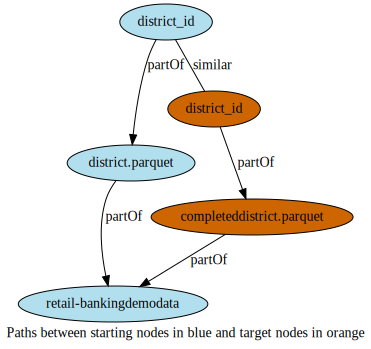

In [15]:
kglids.get_path_between_tables(enrichment_info.iloc[1], hops=1)

**Load <code>entity_df</code>**

In [16]:
entity_df = pd.read_parquet(enrichment_info.iloc[1].Table_path)
entity_df

,district_id,event_timestamp
0,72,2022-06-07 22:33:00.712098
1,18,2022-06-17 16:37:54.712098
2,23,2022-06-08 13:12:24.712098
3,26,2022-06-17 17:55:43.712098
4,16,2022-06-17 16:51:54.712098
...,...,...
95,39,2022-06-08 23:33:00.712098
96,1,2022-06-14 06:42:52.712098
97,13,2022-06-11 05:46:46.712098
98,15,2022-06-13 22:43:57.712098


**Feature recommendation using <code>kgfarm.get_features()</code>**
  *   Pass <code>entity_df</code> as the input to this API in <code>pd.Series</code> format

In [17]:
features = kgfarm.get_features(enrichment_info.iloc[1])
features

['Feature_view_6:state_abbrev',
 'Feature_view_6:division',
 'Feature_view_6:city',
 'Feature_view_6:state_name',
 'Feature_view_6:n_customer_sat',
 'Feature_view_6:net_growth',
 'Feature_view_6:region',
 'Feature_view_6:return',
 'Feature_view_6:avg_sales']

**Enrich <code>entity_df</code> with fresh set of features**

In [18]:
training_data = store.get_historical_features(
    features = features,
    entity_df = entity_df
).to_df()
training_data

,district_id,event_timestamp,state_abbrev,division,city,state_name,n_customer_sat,net_growth,region,return,avg_sales
65,57,2022-06-10 08:22:06.712098+00:00,MA,New England,New Bedford,Massachusetts,3,6873,Northeast,536,899092
83,62,2022-06-13 12:16:31.712098+00:00,NH,New England,Nashua,New Hampshire,2,8897,Northeast,556,1224480
88,33,2022-06-10 23:23:19.712098+00:00,UT,Mountain,Salt Lake City,Utah,4,8043,West,535,1067431
27,33,2022-06-15 12:01:39.712098+00:00,UT,Mountain,Salt Lake City,Utah,4,8043,West,535,1067431
52,50,2022-06-15 12:09:09.712098+00:00,NY,Middle Atlantic,Buffalo,New York,2,5680,Northeast,802,786662
40,50,2022-06-12 16:33:37.712098+00:00,NY,Middle Atlantic,Buffalo,New York,2,5680,Northeast,802,786662
44,59,2022-06-16 21:28:01.712098+00:00,MA,New England,Quincy,Massachusetts,2,3180,Northeast,803,1314499
75,10,2022-06-17 02:45:01.712098+00:00,MI,East North Central,Detroit,Michigan,4,6808,Midwest,204,962730
8,54,2022-06-11 14:40:24.712098+00:00,TX,West South Central,Houston,Texas,4,5425,South,891,1422893
90,54,2022-06-16 01:42:45.712098+00:00,TX,West South Central,Houston,Texas,4,5425,South,891,1422893


**Train a Machine learning model**

In [19]:
from sklearn.linear_model import LinearRegression
features = [feature for feature in training_data.columns if feature not in 
['region', 'state_abbrev', 'city', 'state_name', 'division', 'event_timestamp', 'return']]
X = training_data[features].sort_index(axis=1).sort_values('district_id').reset_index(drop=True)
y = training_data['return']

model = LinearRegression()
model.fit(X, y)

LinearRegression()

**Materializing/loading features to online store using <code>feast masterialize</code>**  [(more info)](https://docs.feast.dev/getting-started/quickstart#step-5-load-features-into-your-online-store)

In [20]:
os.chdir('feature_repo/')
!feast materialize-incremental 2022-06-11
os.chdir('../')

Materializing 12 feature views to 2022-06-10 20:00:00-04:00 into the sqlite online store.

Feature_view_7 from 2022-05-20 23:36:29-04:00 to 2022-06-10 20:00:00-04:00:
100%|█████████████████████████████████████████████████████████| 2290/2290 [00:00<00:00, 6117.40it/s]
Feature_view_1 from 2022-05-20 23:36:29-04:00 to 2022-06-10 20:00:00-04:00:
100%|███████████████████████████████████████████████████████████| 627/627 [00:00<00:00, 1053.02it/s]
Feature_view_5 from 2022-05-20 23:36:30-04:00 to 2022-06-10 20:00:00-04:00:
100%|█████████████████████████████████████████████████████████| 1483/1483 [00:00<00:00, 3067.90it/s]
Feature_view_13 from 2022-05-20 23:36:30-04:00 to 2022-06-10 20:00:00-04:00:
100%|████████████████████████████████████████████████████████| 1743/1743 [00:00<00:00, 12524.43it/s]
Feature_view_14 from 2022-05-20 23:36:31-04:00 to 2022-06-10 20:00:00-04:00:
100%|████████████████████████████████████████████████████████| 1922/1922 [00:00<00:00, 24277.75it/s]
Feature_view_6 from 20

**Fetching feature vector(s) for inference using [<code>get_online_features</code>](https://docs.feast.dev/getting-started/quickstart#step-6-fetching-feature-vectors-for-inference)**

In [21]:
id = 10
feature_vector = store.get_online_features(
    features = kgfarm.get_features(enrichment_info.iloc[1]),
    entity_rows=[
        {'district__completeddistrict': id}
    ],
).to_dict()

[feature_vector.pop(feature) for feature in list(feature_vector.keys()) if feature not in features]
feature_vector

{'district_id': [10],
 'avg_sales': [962730],
 'n_customer_sat': [4],
 'net_growth': [6808]}

**Get predictions in real-time**

In [22]:
prediction = model.predict(pd.DataFrame(feature_vector).sort_index(axis=1))[0]
prediction

619.3901973205506